<img src="../img/hu-logo.png" align="right" width="120">

# Gradient descent

Implement inference for a ___binary classficiation___ using mini-batch gradient descent.

## Reminder

### Formal representation of the problem

Let's look at a binary classification model

$
\quad y_i = \cases{1 \quad \text{if}\ z_i^* > 0\\0 \quad \text{otherwise}}
$

that represents our hypothesis $h$, with

$
\quad z_i^* = \theta^{(k)} f\left( x_i^{(k)} \right) + \varepsilon_i
$

Here, 

- $y_i$ is the dependent variable,
- $x_i$ the feature vector, and
- $\theta$ are the coefficients (or weights).

Assuming a logistic distribution for the error term leads to a closed form solution for class probabilities

$
\quad p(y_i = 1) =  \displaystyle\frac{
\exp\left\{ z_i \right\}
}{
1 + \exp\left\{ z_i \right\}
}
=
\displaystyle\frac{1}{
1 + \exp\left\{ -z_i \right\}
}
$

### Update equations

Gradient descent starts with an initial guess for $\theta$ and then iterates to minimize the cost function $J$ (i.e., maximize the LL function). With the learning rate $\eta$, it follows

$
\quad\displaystyle \theta_k' \\
\quad\quad= \theta_k - \eta\,\partial_\theta J(\theta) \\
\quad\quad= \theta_k - \eta\,\displaystyle\sum_i \big(h_\theta(x_i) - y_i\big) x_k
$

### Gradient descent methods

<img src="../img/gradient-descent.png" width="800">

In [1]:
import tqdm

import numpy as np

import scipy.special
import sklearn.linear_model

import matplotlib.animation
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (10, 8),
    "axes.titlesize": 20,
    "axes.labelsize": 15,
    "legend.fontsize": 15,
    "axes.grid": True,
    "axes.axisbelow": True,
})

## Generate data

In [2]:
N = 10_000

In [3]:
w = np.array([-2, 0.5, -0.3, 0.4])

In [4]:
x = np.vstack([
    np.ones(N),
    np.random.normal(0, 2, N),
    np.random.normal(0, 2, N),
    np.random.normal(0, 2, N),
]).T

In [5]:
z = x.dot(w)

In [6]:
y = np.random.binomial(1., scipy.special.expit(z))

## Estimate model with `sklearn`

In [7]:
lr = sklearn.linear_model.LogisticRegression(C=19, fit_intercept=False)
res = lr.fit(x, y)
res.coef_

array([[-1.9936177 ,  0.49742782, -0.281846  ,  0.38446671]])

## Manual implementation of Batch Gradient Descent

In [8]:
class LogisticRegression(object):

    def __init__(self, b, lr=0.01, batch_size=32):
        self.lr = lr
        self.b = b
        self.batch_size = batch_size
        self.idx = []
        self.epoch_counter = 0
        self.b_epoch = []
        self.c_epoch = []

    def cost(self, x, y):
        yhat = self.predict(x)
        cost_i = -(y*np.log(yhat) + (1-y)*np.log(1-yhat))
        return np.mean(cost_i)

    def step(self, x, y):
        dJ_db = np.dot(x.T, self.predict(x) - y) / x.shape[0]
        self.b = self.b - self.lr*dJ_db

    def train(self, x, y, n_epochs=5_000):
        b_epoch = np.zeros((n_epochs, len(self.b)))
        c_epoch = np.zeros((n_epochs, 1))
        self.idx = np.arange(x.shape[0])
        for i in tqdm.tqdm(range(n_epochs)):
            b_epoch[i, :] = self.b
            c_epoch[i, 0] = self.cost(x, y)
            np.random.shuffle(self.idx)
            idx_i = np.split(
                self.idx[:self.batch_size * (len(self.idx) // self.batch_size)],
                self.batch_size
            )
            for idx_mb in idx_i:
                self.step(x[idx_mb], y[idx_mb])
                self.epoch_counter += n_epochs
        self.b_epoch = b_epoch
        self.c_epoch = c_epoch

    def predict(self, x):
        return scipy.special.expit(np.dot(x, self.b))

    def params(self):
        return self.b

In [9]:
logistic = LogisticRegression(b=np.array([-.8, 0.8, -0.2, 0.2]), lr=0.01)

In [10]:
logistic.train(x, y)

100%|██████████| 5000/5000 [00:06<00:00, 734.23it/s]


In [11]:
logistic.params()

array([-1.9939595 ,  0.4973627 , -0.28177601,  0.38416631])

## Plot cost function

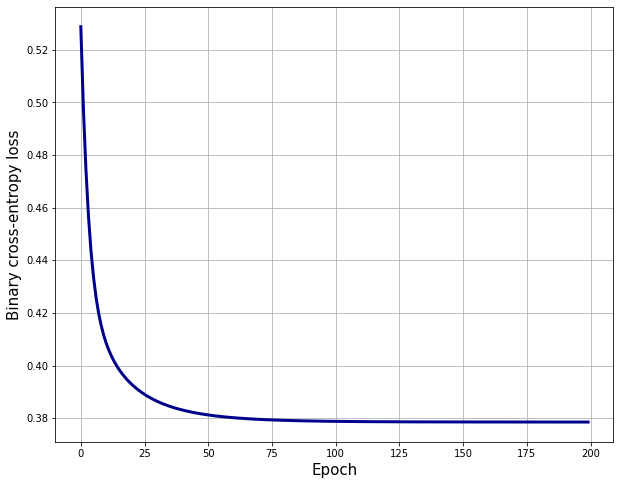

In [12]:
cs = logistic.c_epoch[:200, :]
bs = logistic.b_epoch[:200, :]
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy loss")
plt.plot(cs, linewidth=3, c="darkblue")
plt.show()

## Plot cost function contour

### Static

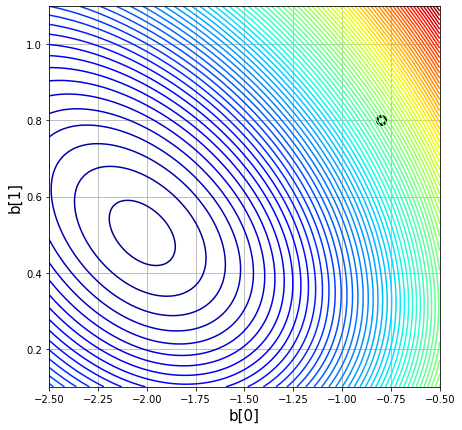

In [13]:
W, B = np.meshgrid(
    np.linspace(-2.5, -0.5, 100),
    np.linspace(0.1, 1.1, 100)
)

def cost(x, y, b):
    yhat = scipy.special.expit(np.dot(x, b))
    cost_i = -(y*np.log(yhat) + (1-y)*np.log(1-yhat))
    return np.mean(cost_i)

zs = np.array([
    cost(x, y, np.array([b0, b1, w[2], w[3]]))
    for b0, b1
    in zip(np.ravel(W), np.ravel(B))
])

Z = zs.reshape(W.shape)

# contour
fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.contour(W, B, Z, 100, cmap="jet")
ax1.set_xlabel("b[0]")
ax1.set_ylabel("b[1]")

plt.scatter(logistic.b_epoch[0,0], logistic.b_epoch[0,1], c="black", s=100)
plt.scatter(logistic.b_epoch[0,0], logistic.b_epoch[0,1], c="white", s=20)

plt.show()

### Animated

In [14]:
def init_1():
    line1.set_data([], [])
    point1.set_data([], [])
    value_display1.set_text("")
    return line1, point1, value_display1

def animate_1(i):
    p_i = p[i]
    line1.set_data(bs[:p_i, 0], bs[:p_i, 1])
    point1.set_data(bs[p_i, 0], bs[p_i, 1])
    value_display1.set_text(f"Cost  = {cs[p_i, 0]:.4f}")
    return line1, point1, value_display1

p = np.arange(bs.shape[0])

linewidth = 2
marker_size = 5
                  
line1, = ax1.plot([], [], "m", label="MBGD", linewidth=linewidth)
point1, = ax1.plot([], [], "*", color="m", markersize=marker_size)
value_display1 = ax1.text(0.02, 0.06, "", transform=ax1.transAxes)
value_display1.set_bbox(dict(facecolor="white", alpha=0.9, edgecolor="white"))

_ = ax1.legend(loc = 1)

anim1 = matplotlib.animation.FuncAnimation(
    fig1,
    animate_1,
    init_func=init_1,
    frames=len(p),
    interval=100,
    repeat_delay=60,
    blit=True
)

_ = anim1.save(
    "../img/gd-contour-logistic.gif",
    writer="pillow",
    dpi=100
)

<img src=../img/gd-contour-logistic.gif width="600">

&mdash; <br>
Dr. Sebastian Gabel <br>
Machine Learning in Marketing &ndash; Lecture 4 <br>
2020 <br>

Based on [Link1](https://towardsdatascience.com/gradient-descent-animation-1-simple-linear-regression-e49315b24672) and [Link2](https://xavierbourretsicotte.github.io/animation_ridge.html)